In [5]:
# from sklearnex import patch_sklearn 
# patch_sklearn()
import pandas as pd
import numpy as np
import pennylane as qml
import tensorflow as tf
import matplotlib.pyplot as plt
import time 

from sklearn.svm import SVC # your usual code without any changes
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import datetime

In [2]:
# Dimension of the bipartite system
dim = '3x3'
cat_size = 200

# Number of Principal components to reduce the dataset's dimensionality
n_pca=32

# We consider training data with a fixed PPT ratio of 0.5, i.e. the 
# proportion of PPT entangled data within the Entangled data of the dataset.
# Reduce the dimensionality of the dataset with Principal Component Analysis
ppt_ratio='1'


x_train = np.genfromtxt('./dataset/'+dim+'/train/x_'+ppt_ratio+'.csv', delimiter=",",dtype=None)
print('x_train ', x_train.shape)
y_train = np.genfromtxt('./dataset/'+dim+'/train/y_train.csv', delimiter=",",dtype=None)
print('y_train ', y_train.shape)

x_test = np.genfromtxt('./dataset/'+dim+'/test/x_test.csv', delimiter=",",dtype=None)
print('x_test ', x_test.shape)
y_test = np.genfromtxt('./dataset/'+dim+'/test/y_test.csv', delimiter=",",dtype=None)
print('y_test ', y_test.shape)

x_train  (2000, 80)
y_train  (2000,)
x_test  (600, 80)
y_test  (600,)


In [4]:
# Dimension of the bipartite system
folder = 'efficiency_study'

# Number of Principal components to reduce the dataset's dimensionality
n_pca=32

# pennylane works with doubles and tensorflow works with floats.
# We ask tensorflow to work with doubles
tf.keras.backend.set_floatx('float64')

# Initialize a seed for np, so that our results are reproducible
np.random.seed(42)

In [5]:
# Amplitude encoding of 64 variables using 5 qubits (can encode up to 32 inputs)
# Number of qubits of the system
nqubits = 5
# We define a device
dev = qml.device("default.qubit", wires = nqubits)

# We define de circuit of our kernel. We use AmplitudeEmbedding which returns an
# operation equivalent to amplitude encoding of the first argument
@qml.qnode(dev)
def kernel_circ(a,b):
    qml.AmplitudeEmbedding(a, wires=range(nqubits), pad_with=0, normalize=True)
    # Computes the adjoint (or inverse) of the amplitude encoding of b
    qml.adjoint(qml.AmplitudeEmbedding(b, wires=range(nqubits), pad_with=0, normalize=True))    # We return an array with the probabilities fo measuring each possible state in the
    # computational basis
    return qml.probs(wires=range(nqubits))

In [6]:
def qkernel(A, B):
  return np.array([[kernel_circ(a,b)[0] for b in B] for a in A])

In [15]:
sizes=np.arange(100, 1001, 100)
pca_times=[]
training_times=[]
prediction_times=[]
total_times=[]
accuracy_n=[]

In [24]:
for size in sizes:
    start=time.time()

    x_train = np.genfromtxt('./dataset/'+folder+'/train/x_n_'+str(size)+'.csv', delimiter=",",dtype=None)
    x_test = np.genfromtxt('./dataset/'+folder+'/test/x_test.csv', delimiter=",",dtype=None)

    start_pca = time.time()

    pca = PCA(n_components = n_pca)
    xs_train = pca.fit_transform(x_train)
    xs_test = pca.transform(x_test)

    end_pca=time.time()
    pca_times.append(end_pca - start_pca)


    y_train = np.genfromtxt('./dataset/'+folder+'/train/y_n_'+str(size)+'.csv', delimiter=",",dtype=None)
    y_test = np.genfromtxt('./dataset/'+folder+'/test/y_test.csv', delimiter=",",dtype=None)

    start_train=time.time()
    svm = SVC(kernel = qkernel).fit(xs_train, y_train)
    end_train=time.time()
    training_times.append(end_train - start_train)

    start_test=time.time()
    y_test_pred=svm.predict(xs_test)
    end_test=time.time()
    prediction_times.append(end_test-start_test)

    test_acc = accuracy_score(y_test_pred, y_test)
    end=time.time()
    total_times.append(end - start)

    accuracy_n.append(test_acc)
    # print("Test accuracy for n = {} : {}".format(size, test_acc))


In [ ]:
# Create a dictionary to save times
d={'size':sizes,'total_time': total_times,'pca_time': pca_times, 'training_time': training_times,
   'prediction_time': prediction_times, 'accuracy': accuracy_n,}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(data=d)

# Save the dataframe to a CSV file
df.to_csv('./results/efficiency_results.csv', index=False)

# Default qubit 

In [29]:
results=pd.read_csv("./results/efficiency_results.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    929.266728  0.600583     232.357716       696.166130  0.683333
1   200   2389.382585  0.003664     920.592516      1468.668005  0.620000
2   300   4897.760765  0.005475    2437.305936      2460.231932  0.640000
3   400   7287.650731  0.003538    4203.814108      3083.713228  0.756667
4   500  10770.610564  0.003259    6773.568293      3996.627862  0.783333
5   600  14489.122067  0.005973    9665.883191      4822.864136  0.773333
6   700  18640.010507  0.004629   13122.012113      5517.763067  0.776667
7   800  22141.673168  0.004902   16084.014137      6057.279932  0.773333
8   900  28693.900316  0.005013   21385.270577      7308.255956  0.770000
9  1000  36496.319263  0.006986   27951.266791      8544.848698  0.780000
146735.696693182
1 day, 16:45:35.696693


In [34]:
# sizes=np.array([100,200,300,400])
# total_times=[1203.5146133899689, 2987.0052218437195, 5389.7877678871155, 8381.283021688461]
# pca_times=[0.6374199390411377, 0.0027985572814941406, 0.0031075477600097656, 0.0032532215118408203]
# training_times= [300.7612683773041, 1190.8078904151917, 2694.8653140068054, 4785.023932695389]
# prediction_times= [901.9093019962311, 1796.0588626861572, 2694.776803255081, 3596.131491661072]


-1620.3897402565508 + 22.93105715041957 x^1 + -0.009586670353987144 x^2 + 2.4372714258277808e-05 x^3
R-squared:  0.9982760608540151
470.78914112638995 + 4.383421604198709 x^1 + 0.03062830817112343 x^2
R-squared:  0.9968076032722634


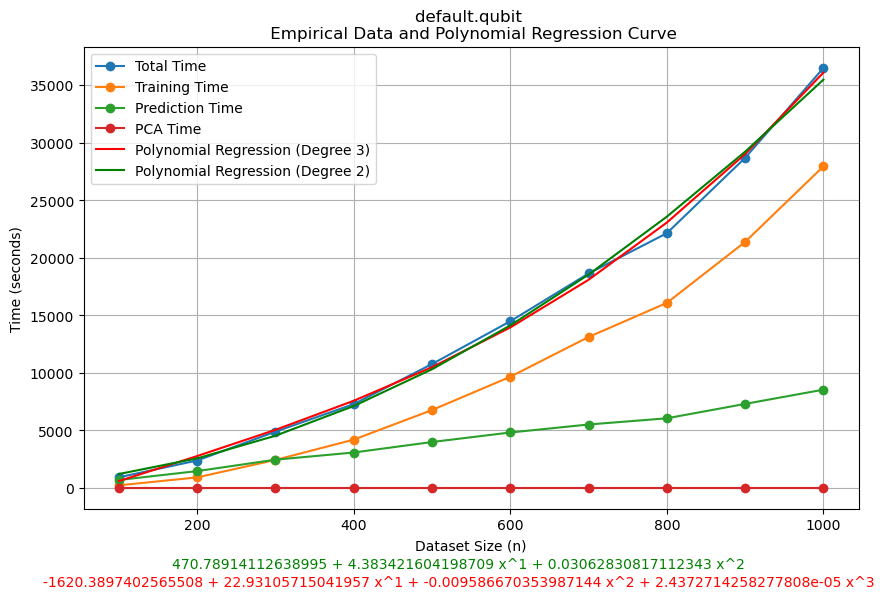

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('default.qubit \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [56]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 1 day, 12:35:50.865034 , 2 days, 7:47:56.757211 ]


# Specs comparison

In [4]:
specs=['default.qubit', 'sklearnex patch', 'lightning.qubit', '4 core MP', '8 core MP', '16 core MP']
total_times=[929.0303208827972, 469.2156777381897, 465.96590399742126, 473.1370894908905, 441.6203305721283, 470.88121700286865]
pca_times=[ 0.0045320987701416016, 1.7428326606750488, 1.5053131580352783, 1.505403757095337, 1.5070369243621826, 2.4730515480041504]
training_times= [232.80273127555847, 115.66362380981445, 114.7699122428894, 117.40771007537842, 110.54020190238953, 117.55744004249573]
prediction_times= [ 696.1845543384552, 351.40579557418823, 349.2262830734253, 353.7597680091858, 329.11009454727173, 350.5866916179657]

In [9]:
# Create a dictionary to save times
d={'spec':specs,'total_time': total_times,'pca_time': pca_times, 'training_time': training_times,
   'prediction_time': prediction_times}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(data=d)

# order by total_time
df=df.sort_values(by=['total_time'], axis=0, ascending=True)

print(df)

# Save the dataframe to a CSV file
df.to_csv('./results/specs_comparison.csv', index=False)

              spec  total_time  pca_time  training_time  prediction_time
4        8 core MP  441.620331  1.507037     110.540202       329.110095
2  lightning.qubit  465.965904  1.505313     114.769912       349.226283
1  sklearnex patch  469.215678  1.742833     115.663624       351.405796
5       16 core MP  470.881217  2.473052     117.557440       350.586692
3        4 core MP  473.137089  1.505404     117.407710       353.759768
0    default.qubit  929.030321  0.004532     232.802731       696.184554


# Lightning qubit, calypso

In [3]:
results=pd.read_csv("./results/efficiency_results_lightning.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100   1273.560808  1.064535     317.331788       955.068503  0.683333
1   200   3181.990865  0.035209    1273.311506      1908.306580  0.620000
2   300   5718.553976  0.007275    2856.188126      2862.114660  0.640000
3   400   8901.770087  0.007838    5078.425956      3823.142623  0.756667
4   500  12704.299502  0.009802    7934.617518      4769.376014  0.783333
5   600  17202.997147  0.012700   11460.917814      5741.754586  0.773333
6   700  22228.121068  0.015745   15557.733918      6670.115800  0.776667
7   800  27925.645162  0.014251   20314.377440      7610.944497  0.773333
8   900  34191.753542  0.015271   25615.479905      8575.835504  0.770000
9  1000  41255.689679  0.018511   31694.082977      9561.242655  0.780000
174584.3818347454
2 days, 0:29:44.381835


-29.979131957214122 + 9.810328185547109 x^1 + 0.03129320853074132 x^2 + 1.4826951750557542e-07 x^3
R-squared:  0.9999951312088797
-17.257608095962496 + 9.697495084945706 x^1 + 0.03153785323337757 x^2
R-squared:  0.9999950907442635


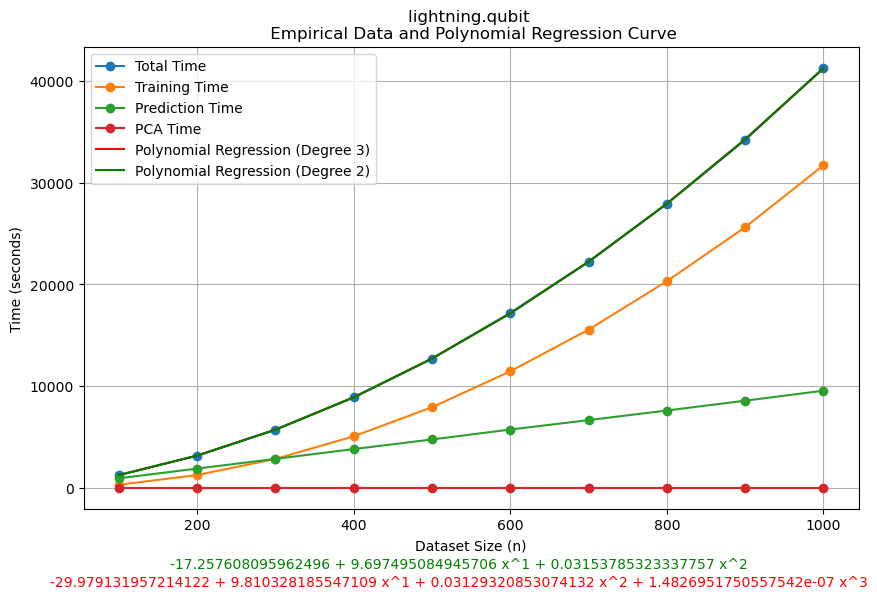

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

# Lightning qubit 8 core MP, hermes

In [6]:
results=pd.read_csv("./results/efficiency_results_8mp.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    771.789937  0.818039     176.194070       594.549498  0.683333
1   200   1928.461535  0.019217     772.640547      1155.653060  0.620000
2   300   3394.067318  0.033309    1791.337812      1602.546435  0.640000
3   400   4916.324630  0.077075    2800.908634      2115.181993  0.756667
4   500   6912.726884  0.009835    4317.122021      2595.431798  0.783333
5   600   9372.093805  0.029892    6237.734886      3134.106789  0.773333
6   700  12102.633476  0.010550    8485.610153      3616.813578  0.776667
7   800  14566.378013  0.008380   10664.614610      3901.470500  0.773333
8   900  22259.009945  0.008840   16682.220264      5576.371022  0.770000
9  1000  27725.037351  0.027275   21307.719643      6416.944501  0.780000
103948.52289247513
1 day, 4:52:28.522892


-1399.1338040305163 + 22.837806139080236 x^1 + -0.03314095357418284 x^2 + 3.964449534824559e-05 x^3
R-squared:  0.9951839843147029
2002.3638954252892 + -7.331654814719725 x^1 + 0.032272463745241745 x^2
R-squared:  0.9884216459760881


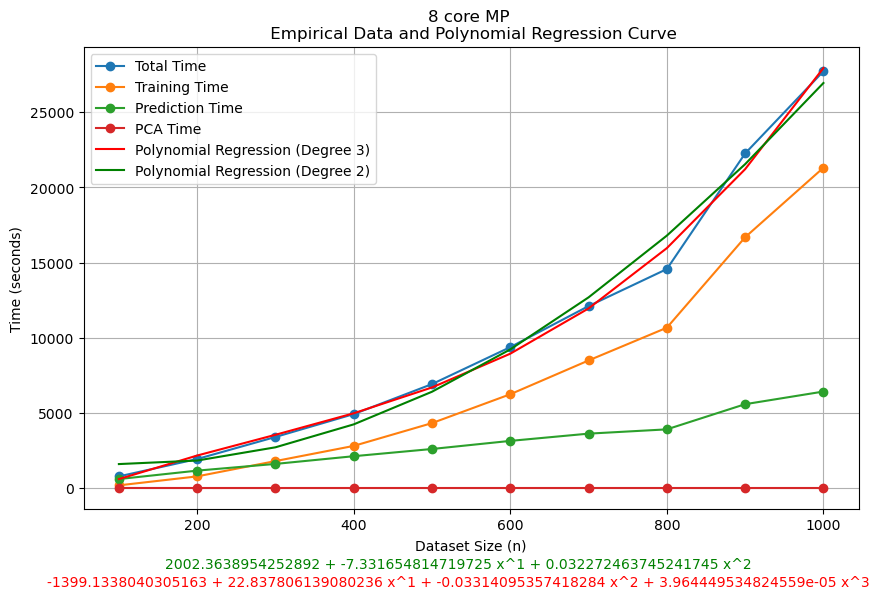

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('8 core MP \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [8]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 1 day, 8:20:28.909247 , 2 days, 15:34:28.626963 ]


# Lightning qubit 8 core MP, calypso

In [2]:
results=pd.read_csv("./results/efficiency_results_8mp_last.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100   1289.586580  0.555007     321.472606       967.314065  0.683333
1   200   3215.859805  0.024765    1284.213494      1931.469322  0.620000
2   300   5790.479721  0.009417    2893.586318      2896.666311  0.640000
3   400   9050.817406  0.032768    5160.415445      3890.157297  0.756667
4   500  12909.876296  0.010218    8064.657273      4844.985754  0.783333
5   600  17494.248748  0.015356   11653.156321      5840.707420  0.773333
6   700  22587.111001  0.013922   15805.372957      6781.452769  0.776667
7   800  28404.148120  0.015056   20658.951423      7744.832149  0.773333
8   900  34748.838078  0.017470   26024.729284      8723.489348  0.770000
9  1000  41940.952487  0.017549   32220.995857      9719.577270  0.780000
177431.91824364662
2 days, 1:17:11.918244


-32.65143263596474 + 9.865264624794523 x^1 + 0.032111408448109426 x^2 + -4.2791864986745235e-08 x^3
R-squared:  0.9999930893148388
-36.32297500843197 + 9.897829237647906 x^1 + 0.03204080186666687 x^2
R-squared:  0.9999930860557302


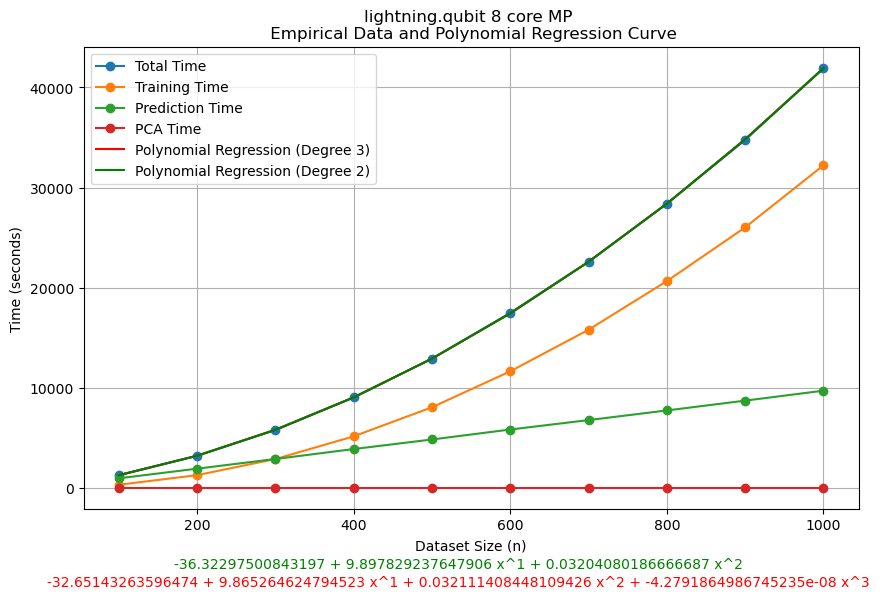

In [5]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit 8 core MP \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [4]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 1 day, 17:05:22.542967 , 1 day, 17:03:21.176689 ]


# ONLY Lightning qubit, metis

In [2]:
results=pd.read_csv("./results/efficiency_results_lightning_hermes.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    488.126466  0.870821     121.684468       365.408996  0.683333
1   200   1234.168650  0.004704     495.331991       738.731471  0.620000
2   300   2211.117604  0.003539    1108.244278      1102.649829  0.640000
3   400   3436.286387  0.003382    1964.615750      1471.479427  0.756667
4   500   4915.035409  0.003744    3069.287130      1845.588295  0.783333
5   600   6589.493778  0.005851    4416.771318      2172.509977  0.773333
6   700   8380.762159  0.005022    5866.828146      2513.751156  0.776667
7   800  10512.867191  0.005283    7649.609377      2863.059979  0.773333
8   900  12613.336981  0.007421    9625.006823      2988.031692  0.770000
9  1000  14351.314730  0.005184   10936.267946      3414.716926  0.780000
64732.50935649872
17:58:52.509356


286.6005706175565 + 0.4554032098572724 x^1 + 0.021674435459945494 x^2 + -7.96191422303537e-06 x^3
R-squared:  0.9996847281396753
-396.53166976016655 + 6.51441993366779 x^1 + 0.00853727699192923 x^2
R-squared:  0.998764684102345


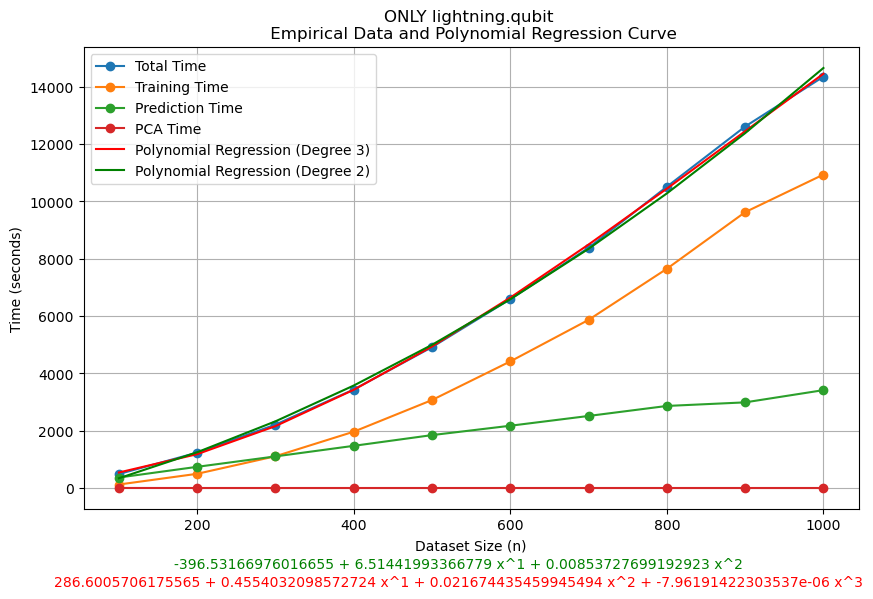

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('ONLY lightning.qubit \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [4]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 12:59:41.416165 , 6:43:19.835046 ]


# Lightning qubit 8 core MP, metis

In [6]:
results=pd.read_csv("./results/efficiency_results_8mp_hermes.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    478.293094  0.091310     119.650742       358.296440  0.683333
1   200   1185.647235  0.939143     475.814951       708.777825  0.620000
2   300   2117.721484  0.102713    1063.608622      1053.866384  0.640000
3   400   3306.173404  0.100247    1888.872128      1417.048362  0.756667
4   500   4725.226308  0.794846    2944.082343      1780.184824  0.783333
5   600   6414.699220  0.637623    4267.077286      2146.769248  0.773333
6   700   8222.444331  0.631154    5754.547733      2467.061171  0.776667
7   800  10190.032335  0.895178    7448.366887      2740.517344  0.773333
8   900  12328.411605  0.894826    9222.324585      3104.886979  0.770000
9  1000  14648.342973  0.895556   11295.600866      3351.327315  0.780000
63616.99198937416
17:40:16.991989


79.68929198033948 + 2.551123939541428 x^1 + 0.015124454584547175 x^2 + -3.1207380986491592e-06 x^3
R-squared:  0.9999850089810061
-188.07003709119 + 4.92600563314064 x^1 + 0.0099752367215617 x^2
R-squared:  0.9998443232928321


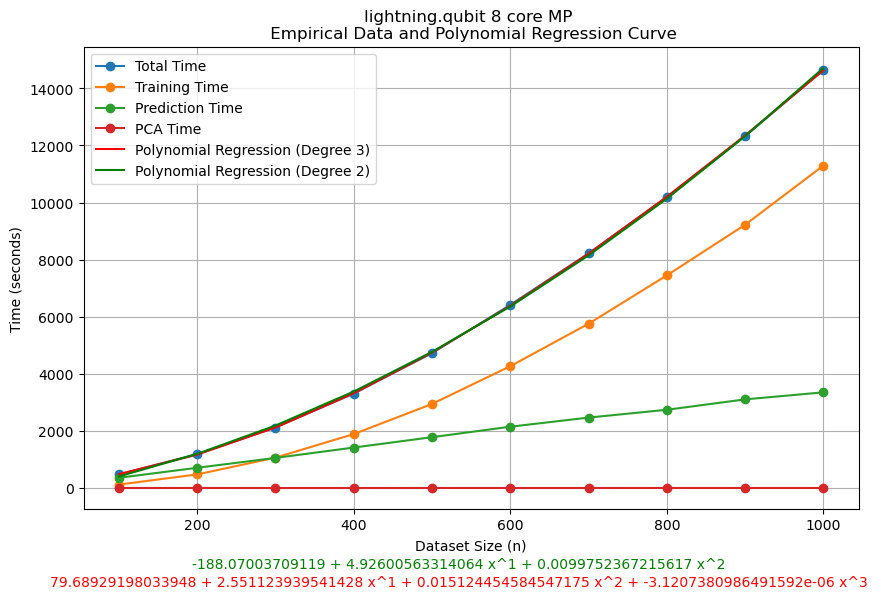

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit 8 core MP \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [8]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 13:46:04.888115 , 11:18:33.850720 ]


# Lightning qubit 16 MP

In [2]:
results=pd.read_csv("./results/efficiency_results_16mp.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    465.573079  0.670882     117.280912       347.457850  0.683333
1   200   1191.847605  0.088789     466.927168       724.678989  0.620000
2   300   2122.963584  0.003770    1057.243149      1065.531389  0.640000
3   400   3199.027988  0.015654    1835.668057      1363.234690  0.756667
4   500   4524.863484  0.027277    2828.714668      1695.999672  0.783333
5   600   6126.120555  0.057510    4079.885054      2046.000329  0.773333
6   700   7898.391049  0.005569    5528.680229      2369.548176  0.776667
7   800   9926.052507  0.253910    7222.241829      2703.385856  0.773333
8   900  12152.106447  0.196904    9098.956193      3052.736210  0.770000
9  1000  14609.415993  0.156364   11246.537579      3362.527683  0.780000
62216.36229014397
17:16:56.362290


-13.256082109362978 + 3.9005857268796236 x^1 + 0.01022630067146354 x^2 + 5.039484390958813e-07 x^3
R-squared:  0.9999853596735275
29.982693612347248 + 3.517080965406018 x^1 + 0.011057815595918804 x^2
R-squared:  0.9999816119831595


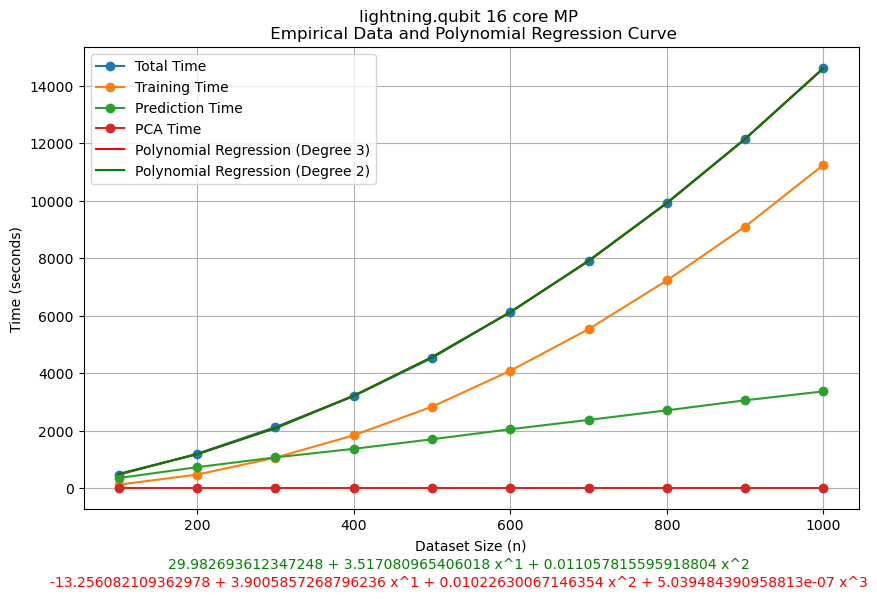

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit 16 core MP \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [5]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 14:14:55.407008 , 14:38:44.705570 ]


# Comparison 8 and 16 cores

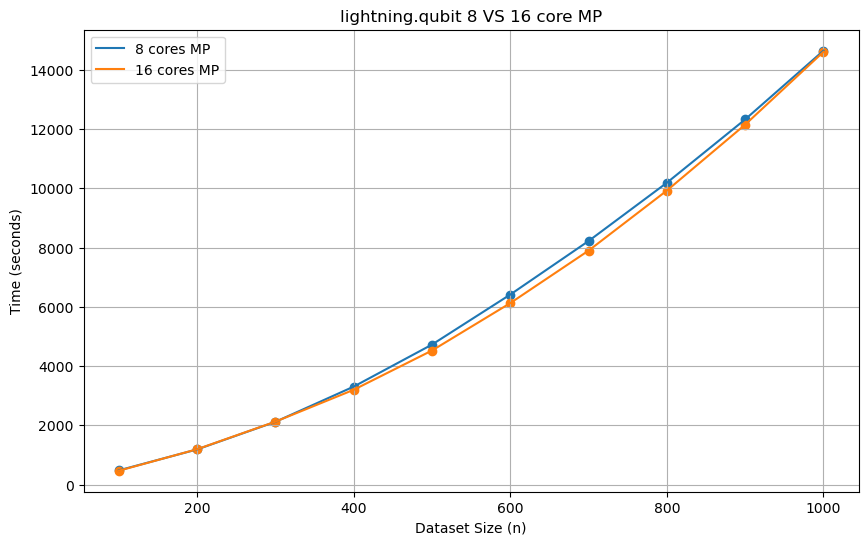

In [7]:
results_8mp=pd.read_csv("./results/efficiency_results_8mp_hermes.csv")
results_16mp=pd.read_csv("./results/efficiency_results_16mp.csv")

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results_8mp['size'], results_8mp['total_time'], label='8 cores MP')
plt.scatter(results_8mp['size'], results_8mp['total_time'])
plt.plot(results_16mp['size'], results_16mp['total_time'], label='16 cores MP')
plt.scatter(results_16mp['size'], results_16mp['total_time'])

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit 8 VS 16 core MP')
plt.legend()
plt.grid(True)
plt.show()

It doesn't seem that using 16 core MP provide a significant improvement

# Accuracy sizetest

In [3]:
classical=pd.read_csv("./results/3x3/classical_svm_sizetest.csv")
print(classical.head())


   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1     0.9920  0.624333  0.696240   0.733365  0.6990   
1   200          1     1.0000  0.543667  0.520671   0.837762  0.3950   
2   300          1     1.0000  0.663000  0.711629   0.824856  0.6285   
3   400          1     0.9990  0.699667  0.751754   0.837273  0.6830   
4   500          1     0.9984  0.754333  0.807896   0.843881  0.7750   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy      time  
0           0.624333         0.475         0.635          0.763  0.809467  
1           0.543667         0.841         0.353          0.437  1.611324  
2           0.663000         0.732         0.598          0.659  2.710170  
3           0.699667         0.733         0.605          0.761  4.422566  
4           0.754333         0.713         0.740          0.810  6.474079  


In [4]:
quantum=pd.read_csv("./results/3x3/qsvm_sizetest.csv")
print(quantum.head())

   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1   1.000000  0.676667  0.736413   0.806548  0.6775   
1   200          1   1.000000  0.701667  0.739447   0.885017  0.6350   
2   300          1   0.983333  0.738333  0.778561   0.893204  0.6900   
3   400          1   0.972500  0.765000  0.803894   0.905956  0.7225   
4   500          1   0.960000  0.755000  0.794406   0.901587  0.7100   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy         time  
0            0.67625         0.675         0.600          0.755   916.561971  
1            0.73500         0.835         0.540          0.730  2330.862180  
2            0.76250         0.835         0.650          0.730  4009.516277  
3            0.78625         0.850         0.650          0.795  6130.382988  
4            0.77750         0.845         0.635          0.785  8887.339112  


In [5]:
quantum_64=pd.read_csv("./results/3x3/qsvm_64pca_filelock.csv")
print(quantum_64.head())

   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1      1.000  0.723333  0.785530   0.812834  0.7600   
1   200          1      1.000  0.768333  0.815894   0.867606  0.7700   
2   300          1      1.000  0.810000  0.852332   0.884409  0.8225   
3   400          1      0.995  0.811667  0.853056   0.888889  0.8200   
4   500          1      0.994  0.833333  0.873418   0.884615  0.8625   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy          time  
0            0.70500         0.650         0.690          0.830   1736.483106  
1            0.76750         0.765         0.685          0.855   4520.946435  
2            0.80375         0.785         0.760          0.885   7643.343290  
3            0.80750         0.795         0.775          0.865  11972.459631  
4            0.81875         0.775         0.800          0.925  17100.964935  


In [9]:
quantum_NOpca=pd.read_csv("./results/3x3/qsvm_NOpca_filelock.csv")
print(quantum_NOpca.head())

   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1   0.990000  0.615000  0.710889   0.711779  0.7100   
1   200          1   0.955000  0.611667  0.673212   0.766773  0.6000   
2   300          1   0.953333  0.658333  0.719562   0.794562  0.6575   
3   400          1   0.945000  0.650000  0.719251   0.772989  0.6725   
4   500          1   0.958000  0.721667  0.779974   0.824513  0.7400   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy          time  
0            0.56750         0.425         0.665          0.755   3768.997994  
1            0.61750         0.635         0.555          0.645  10325.030679  
2            0.65875         0.660         0.615          0.700  18709.626864  
3            0.63875         0.605         0.605          0.740  28009.404417  
4            0.71250         0.685         0.690          0.790  42353.855682  


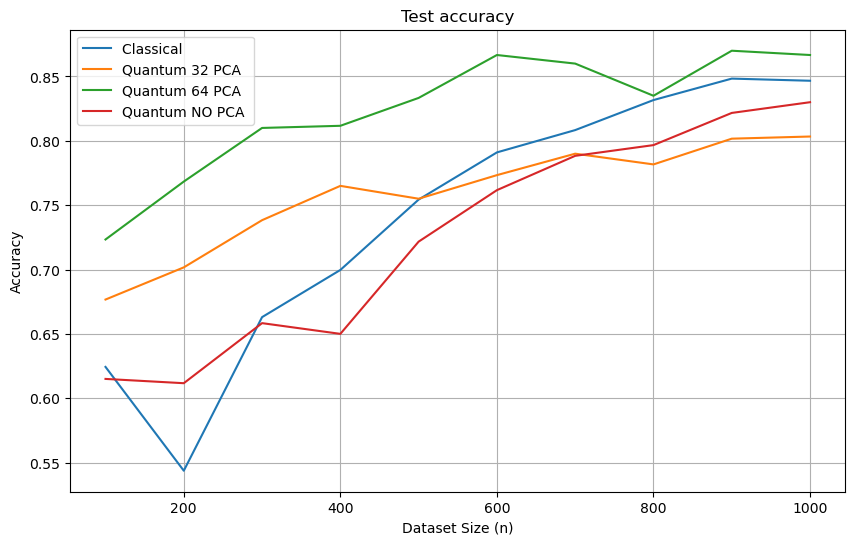

In [10]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(classical['size'], classical['accuracy'], label='Classical ')
plt.plot(quantum['size'], quantum['accuracy'], label='Quantum 32 PCA ')
plt.plot(quantum_64['size'], quantum_64['accuracy'], label='Quantum 64 PCA ')
plt.plot(quantum_NOpca['size'], quantum_NOpca['accuracy'], label='Quantum NO PCA ')

plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.legend()
plt.grid(True)
plt.show()

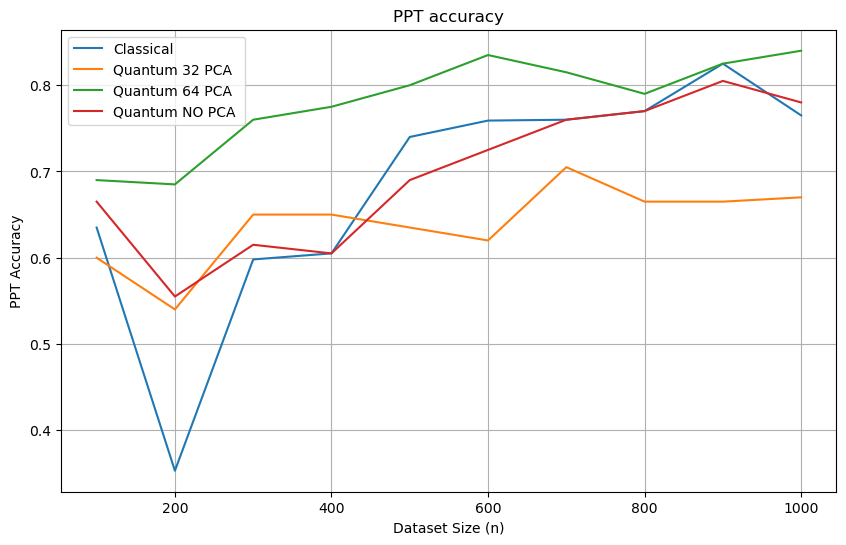

In [11]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(classical['size'], classical['PPT_accuracy'], label='Classical')
plt.plot(quantum['size'], quantum['PPT_accuracy'], label='Quantum 32 PCA')
plt.plot(quantum_64['size'], quantum_64['PPT_accuracy'], label='Quantum 64 PCA ')
plt.plot(quantum_NOpca['size'], quantum_NOpca['PPT_accuracy'], label='Quantum NO PCA ')

plt.xlabel('Dataset Size (n)')
plt.ylabel('PPT Accuracy')
plt.title('PPT accuracy')
plt.legend()
plt.grid(True)
plt.show()

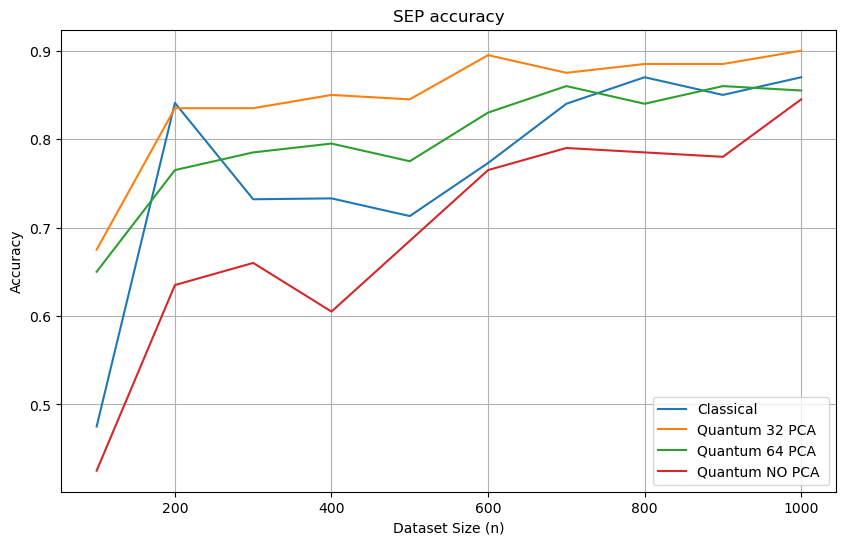

In [12]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(classical['size'], classical['SEP_accuracy'], label='Classical')
plt.plot(quantum['size'], quantum['SEP_accuracy'], label='Quantum 32 PCA')
plt.plot(quantum_64['size'], quantum_64['SEP_accuracy'], label='Quantum 64 PCA ')
plt.plot(quantum_NOpca['size'], quantum_NOpca['SEP_accuracy'], label='Quantum NO PCA ')

plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('SEP accuracy')
plt.legend()
plt.grid(True)
plt.show()

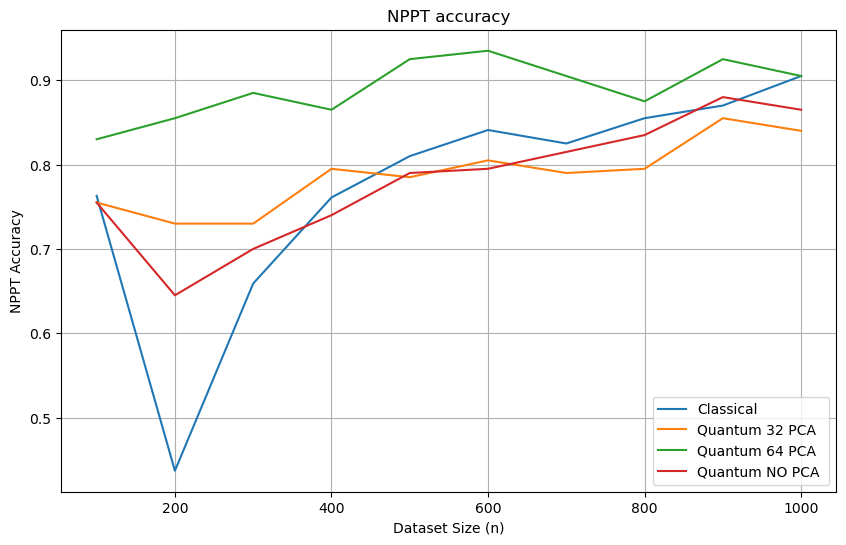

In [13]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(classical['size'], classical['NPPT_accuracy'], label='Classical')
plt.plot(quantum['size'], quantum['NPPT_accuracy'], label='Quantum 32 PCA')
plt.plot(quantum_64['size'], quantum_64['NPPT_accuracy'], label='Quantum 64 PCA')
plt.plot(quantum_NOpca['size'], quantum_NOpca['NPPT_accuracy'], label='Quantum NO PCA ')

plt.xlabel('Dataset Size (n)')
plt.ylabel('NPPT Accuracy')
plt.title('NPPT accuracy')
plt.legend()
plt.grid(True)
plt.show()

We obtain best results with 64 PCA, that is, using a 6 qubits device. Even if we use all 81 attributes of the data and use a 7 qubit device with amplitude encoding, this does not provide an advantage in the results, instead it is worst. I believe because with 7 qubits and amplitude encoding we can codify up to 128 attributes, so we add padding of 0 and I guess this affects the performance of the quantum support vector machine.

# Complexity analysis

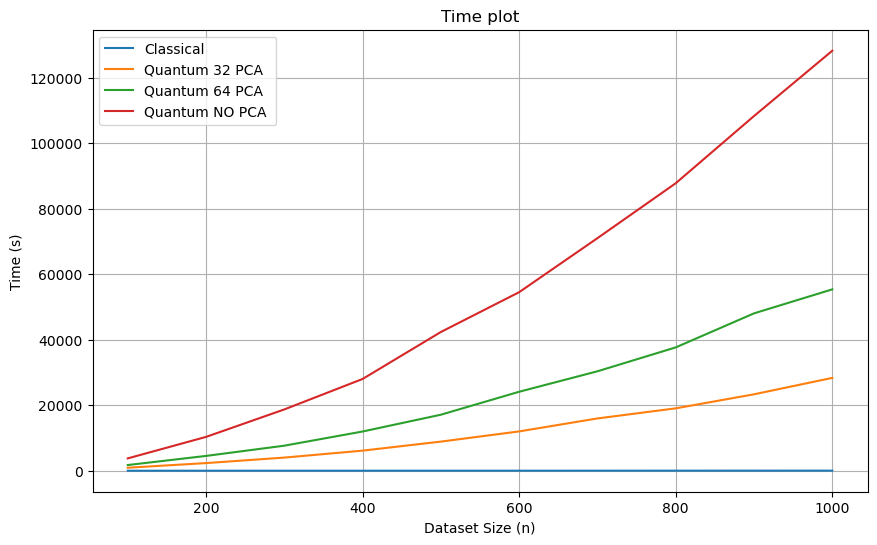

In [14]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(classical['size'], classical['time'], label='Classical')
plt.plot(quantum['size'], quantum['time'], label='Quantum 32 PCA')
plt.plot(quantum_64['size'], quantum_64['time'], label='Quantum 64 PCA')
plt.plot(quantum_NOpca['size'], quantum_NOpca['time'], label='Quantum NO PCA ')

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (s)')
plt.title('Time plot')
plt.legend()
plt.grid(True)
plt.show()

But these times do not match the previous study of complexity with 8 MP (32 PCA), but it does not make sense that it is due to filelock blocking operations. Anyway, let's study the complexity for 3x3 using 64 PCA and 8 core MP.

# 64 PCA lightning.qubit 8 core MP, metis

767.1976767715096 + 5.477135261825797 x^1 + 0.06142289430332031 x^2 + -1.1828369489717347e-05 x^3
R-squared:  0.9991039194448151
-247.67642573241028 + 14.47852444518907 x^1 + 0.04190608464361803 x^2
R-squared:  0.998965548962545


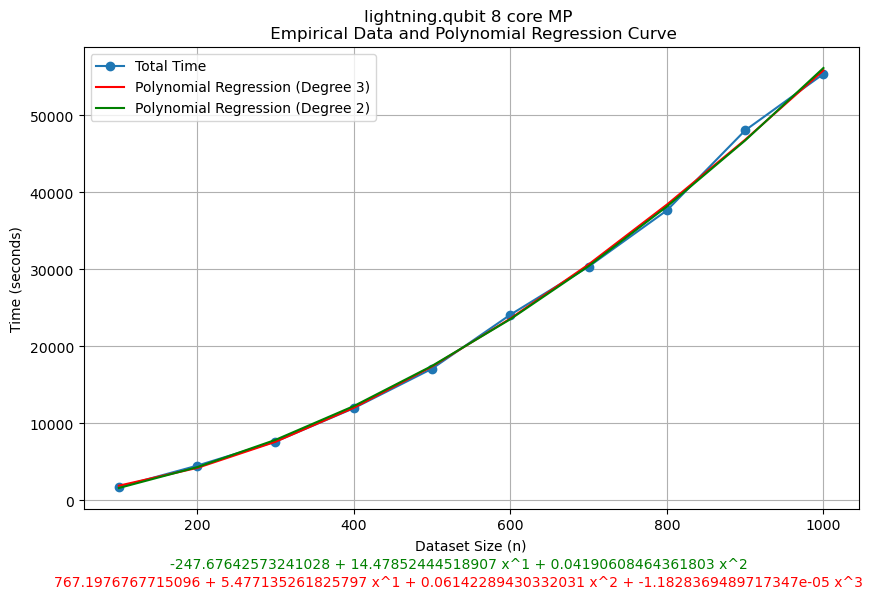

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(quantum_64['size'], quantum_64['time'], label='Total Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(quantum_64['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, quantum_64['time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(quantum_64['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(quantum_64['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, quantum_64['time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(quantum_64['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(quantum_64['time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(quantum_64['time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('lightning.qubit 8 core MP \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [16]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 2 days, 6:32:13.711039 , 1 day, 21:13:06.089496 ]


## Full dataset 64 PCA

In [3]:
quantum=pd.read_csv("./results/3x3/qsvm_test_64pca.csv")
print(quantum.head())

   PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0          1     0.9745  0.876667  0.905612   0.924479  0.8875   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy         time  
0            0.87125         0.855          0.84          0.935  203525.4669  


In [7]:
print(str(datetime.timedelta(seconds=float(quantum['time']))))

2 days, 8:32:05.466900


C:\Users\anama\AppData\Local\Temp\ipykernel_7576\232046712.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(str(datetime.timedelta(seconds=float(quantum['time']))))


# Using JIT

In [16]:
JIT_results=pd.read_csv("./results/3x3/qsvm_32pca_jit.csv")
print(JIT_results.head())

   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1   0.940000  0.586667  0.667560   0.719653  0.6225   
1   200          1   0.840000  0.410000  0.240343   0.848485  0.1400   
2   300          1   0.956667  0.510000  0.610080   0.649718  0.5750   
3   400          1   0.887500  0.488333  0.492562   0.726829  0.3725   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy        time  
0            0.56875         0.515         0.645          0.600   78.189747  
1            0.54500         0.950         0.140          0.140  155.226751  
2            0.47750         0.380         0.525          0.625  287.096093  
3            0.54625         0.720         0.365          0.380  435.692338  


In [17]:
quantum=pd.read_csv("./results/3x3/qsvm_sizetest.csv")
print(quantum.head())

   size  PPT_ratio  acc_train  accuracy        f1  precision  recall  \
0   100          1   1.000000  0.676667  0.736413   0.806548  0.6775   
1   200          1   1.000000  0.701667  0.739447   0.885017  0.6350   
2   300          1   0.983333  0.738333  0.778561   0.893204  0.6900   
3   400          1   0.972500  0.765000  0.803894   0.905956  0.7225   
4   500          1   0.960000  0.755000  0.794406   0.901587  0.7100   

   balanced_accuracy  SEP_accuracy  PPT_accuracy  NPPT_accuracy         time  
0            0.67625         0.675         0.600          0.755   916.561971  
1            0.73500         0.835         0.540          0.730  2330.862180  
2            0.76250         0.835         0.650          0.730  4009.516277  
3            0.78625         0.850         0.650          0.795  6130.382988  
4            0.77750         0.845         0.635          0.785  8887.339112  


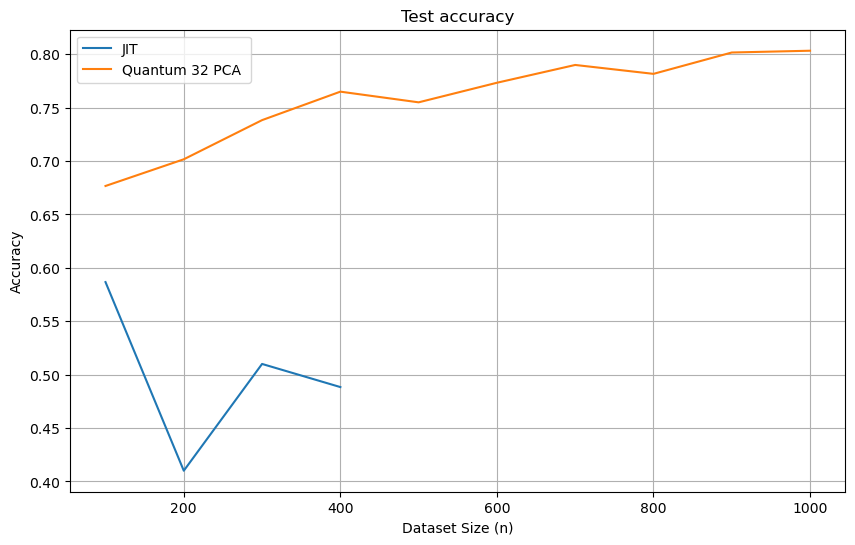

In [18]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(JIT_results['size'], JIT_results['accuracy'], label='JIT ')
plt.plot(quantum['size'], quantum['accuracy'], label='Quantum 32 PCA ')


plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.legend()
plt.grid(True)
plt.show()

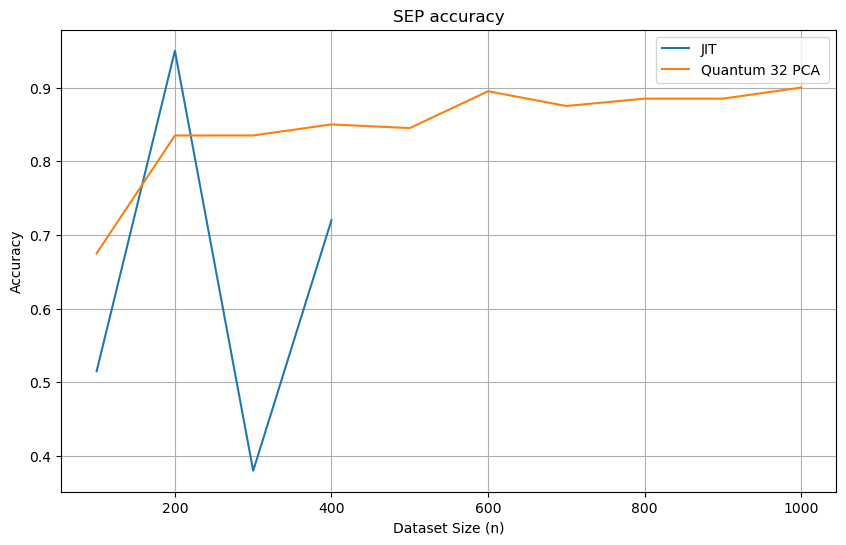

In [23]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(JIT_results['size'], JIT_results['SEP_accuracy'], label='JIT ')
plt.plot(quantum['size'], quantum['SEP_accuracy'], label='Quantum 32 PCA ')


plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('SEP accuracy')
plt.legend()
plt.grid(True)
plt.show()

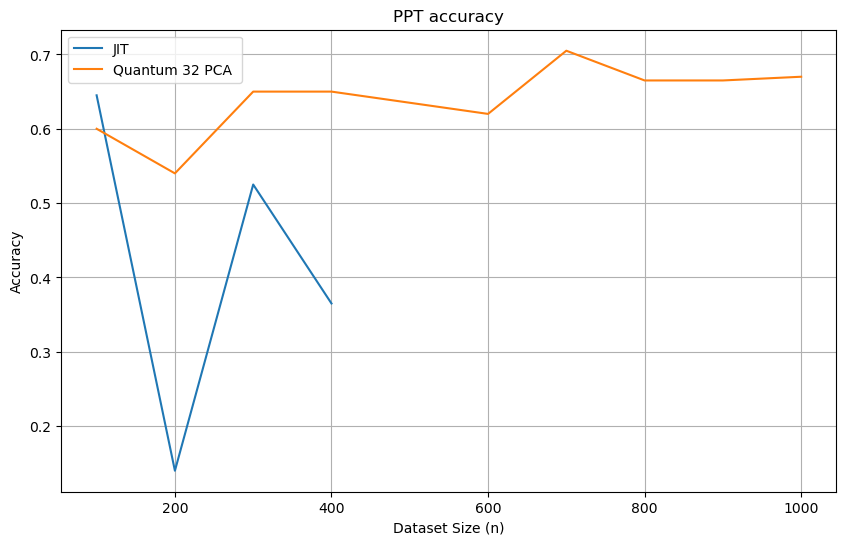

In [24]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(JIT_results['size'], JIT_results['PPT_accuracy'], label='JIT ')
plt.plot(quantum['size'], quantum['PPT_accuracy'], label='Quantum 32 PCA ')


plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('PPT accuracy')
plt.legend()
plt.grid(True)
plt.show()

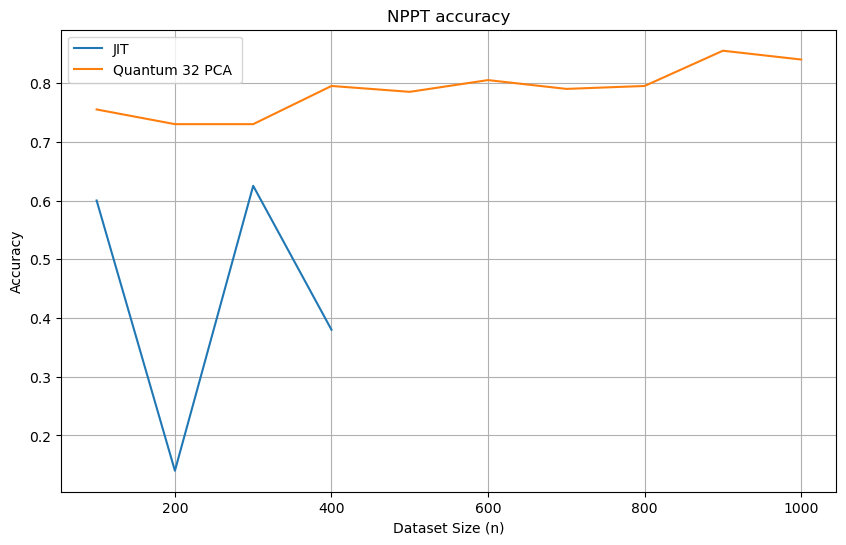

In [25]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(JIT_results['size'], JIT_results['NPPT_accuracy'], label='JIT ')
plt.plot(quantum['size'], quantum['NPPT_accuracy'], label='Quantum 32 PCA ')


plt.xlabel('Dataset Size (n)')
plt.ylabel('Accuracy')
plt.title('NPPT accuracy')
plt.legend()
plt.grid(True)
plt.show()

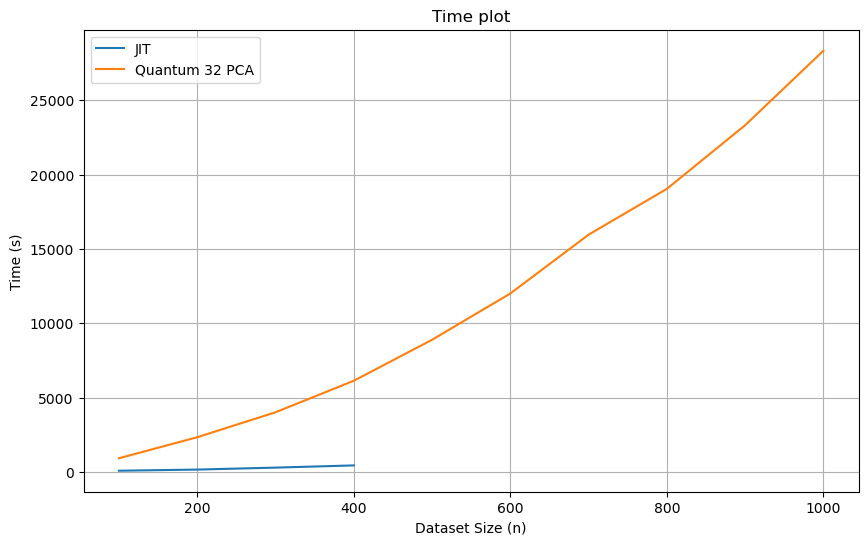

In [22]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(JIT_results['size'], JIT_results['time'], label='JIT')
plt.plot(quantum['size'], quantum['time'], label='Quantum 32 PCA')

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (s)')
plt.title('Time plot')
plt.legend()
plt.grid(True)
plt.show()

Clearly there is a massive time improvement but at cost of lots of memory usage (+ 10 gb) for n=500. 

In addition, what about the terrible performance when JIT compiled? Why? It does not make sense